In [1]:
import json
import pandas as pd
import glob
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
import re
import collections
import os
import seaborn as sns
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_decomposition import CCA
from scipy.spatial import distance
from scipy.stats import pearsonr
import numpy as np
from sklearn.model_selection import train_test_split
from concurrent.futures import ProcessPoolExecutor
from random import sample

In [2]:
def cca_similarity(X_cca,Y_cca):
    cca = CCA(n_components=1)
    cca.fit(X_cca, Y_cca)

    X_c, Y_c = cca.transform(X_cca, Y_cca)
    return (pearsonr(X_c.flatten(),Y_c.flatten())[0])
    
def pca_process (X,n_com):
    # scaler = StandardScaler()
    # X_0 = scaler.fit_transform(X) 
    X_0 = X
    pca = decomposition.PCA(n_components=n_com)
    pca.fit(X_0)
    X_0 = pca.transform(X_0)
    return X_0
def pca_similarity (X,Y):
    return pearsonr(pca_process(X).flatten(),pca_process(Y).flatten())[0]

def matrix_norm (X,Y,n_com):
    return np.linalg.norm(pca_process(X,n_com).flatten() - pca_process(Y,n_com).flatten())
def average_norm (X,Y):
    return np.linalg.norm(np.array(X.T.mean()) - np.array(Y.T.mean()))
    
def similarity_vector(df, pid, method):
    X_cca = df.drop(columns=['playlist_pid','track_uri']).T
    similarity_list = []
    list_temp = unique_playlist.copy()
    list_temp.remove(pid)
#     print (unique_playlist)
    for j in list_temp:
        Y_cca = df_similarity[df_similarity['playlist_pid'] == j]
        Y_cca = Y_cca.drop(columns=['playlist_pid','track_uri']).T
        try:
            if method == 'pca':
                sim = pca_similarity(X_cca,Y_cca)
            elif method == 'matrix norms':
                sim = matrix_norm(X_cca,Y_cca,2)
            elif method == 'cca':
                sim = cca_similarity(X_cca,Y_cca)
            elif method == 'average':
                sim = average_norm(X_cca,Y_cca)
                
            similarity_list.append({'pid_1':pid, 'pid_2':j, 'similarity': sim})
                
        except Exception as e:
            print (e)
            print (pid,j)
    return similarity_list
    
    
def get_pca_comp (df,n_com):
    X_cca = df
    X_cca = X_cca.drop(columns=['playlist_pid','track_uri']).T
    return pca_process(X_cca,n_com)
    
    
def preprocess (df):
    df_temp = df.copy()
    scaler = MinMaxScaler()
    df_temp = df_temp.drop(columns=['playlist_pid','track_uri'])
    data_tranformed = df_temp.T
    data_tranformed = scaler.fit_transform(data_tranformed) 
    df_temp = pd.DataFrame(data_tranformed.T, index=df_temp.index,columns=df_temp.columns)
    df_temp['playlist_pid'] = df.playlist_pid
    df_temp['track_uri'] = df.track_uri
    return df_temp
    
def track_similarity (df, lst_playlist):
    playlist_feature = get_pca_comp (df,1).flatten().T
#     print (playlist_feature)
    track_sim = []
    for i in lst_playlist:
        df_temp = df_similarity[df_similarity['playlist_pid'] == i]
        # df_temp = preprocess(df_temp)
        for j,r in df_temp.iterrows():
            r_temp = r.copy()
            r_temp = r_temp.drop(labels=['playlist_pid','track_uri'])
            cosine_sim = np.dot(playlist_feature,r_temp)/(np.linalg.norm(playlist_feature)*np.linalg.norm(r_temp))
            track_sim.append({'track_uri':r['track_uri'], "similarity": cosine_sim})
    return track_sim

def r_precision (G,R):
    set1 = set(G)
    set2 = set(R)
    set_inter = set2.intersection(set1)
    return len(set_inter)/len(G), list(set_inter)

def cv_r_precision (pid):
    score_cv = []
    for j in range(5):
        df_groundtruth = df_similarity[df_similarity['playlist_pid'] == pid]
        X, y = train_test_split(df_groundtruth, test_size=0.3, random_state=j)
        l = similarity_vector(X,pid, 'matrix norms')
        df_sim_result = pd.DataFrame(l)
        top_sim_list = list(df_sim_result.sort_values("similarity").head(100).pid_2)+list(df_sim_result.sort_values("similarity").tail(10).pid_2)
        track_similar = track_similarity(X,top_sim_list)
        df_track = pd.DataFrame(track_similar)
        lst1 = list(y.track_uri) 
        lst2 = list(df_track.sort_values("similarity").head(400).track_uri) + list(df_track.sort_values("similarity").tail(100).track_uri)
        score, _ = r_precision(lst1,lst2)
        score_cv.append(score)
        print ('done with',j,  'iteration for playlist:', pid)
    
    print ('cv_score for playlist', pid, 'is:', np.mean(score_cv))
    return [np.mean(score_cv),pid]

In [3]:
df = pd.read_csv('data_withmeta/combined_data_withmeta.csv')

In [4]:
feature_list = ['danceability', 'energy', 'key', 'loudness', 'mode', \
       'speechiness', 'acousticness', 'instrumentalness', 'liveness', \
       'valence', 'tempo', 'num_tracks', 'num_albums',
       'num_followers', 'num_edits', 'duration_ms_playlist', 'num_artists']

In [19]:
unique_playlist = list(df['playlist_pid'].unique())
df_similarity = df[feature_list + ['playlist_pid','track_uri']]
df_similarity = df_similarity.dropna()
df_similarity = preprocess (df_similarity)

r_scores = []
subset = sample(unique_playlist,1000)

In [31]:
df_209_groundtruth = df_similarity[df_similarity['playlist_pid'] == 516000]
X_209, y_209 = train_test_split(df_209_groundtruth, test_size=0.3, random_state=42)

In [32]:
l = similarity_vector(X_209,516000, 'matrix norms')

In [33]:
df_sim_result = pd.DataFrame(l)

In [38]:
df_sim_result.sort_values("similarity").tail(5)

,pid_1,pid_2,similarity
2818,516000,341076,11.366422
985,516000,516598,11.397256
1394,516000,958796,11.428019
1005,516000,958487,11.428021
5640,516000,290425,11.428022


In [40]:
def check_result_sim (pid1,pid2,feature_list):
    playlist_1 = df[df['playlist_pid'] == pid1]
    playlist_1 = playlist_1[feature_list+['playlist_pid']]
    playlist_2 = df[df['playlist_pid'] == pid2]
    playlist_2 = playlist_2[feature_list+['playlist_pid']]
    df_merged = pd.concat([playlist_1,playlist_2], ignore_index=True)
    for i in range(len(feature_list)):
        sns.displot(df_merged, palette="pastel",x=feature_list[i],hue='playlist_pid', fill=True)

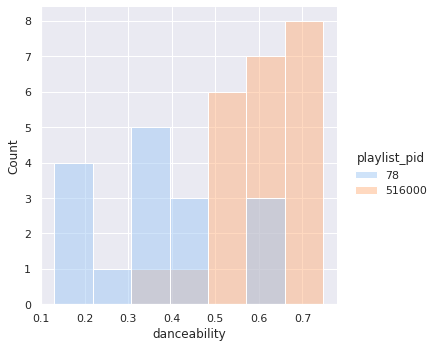

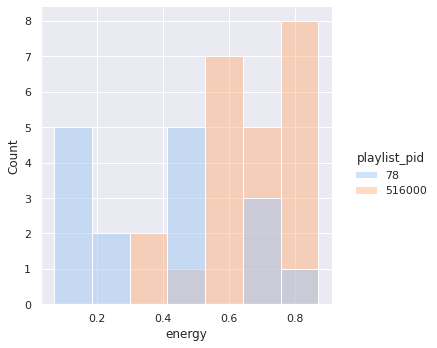

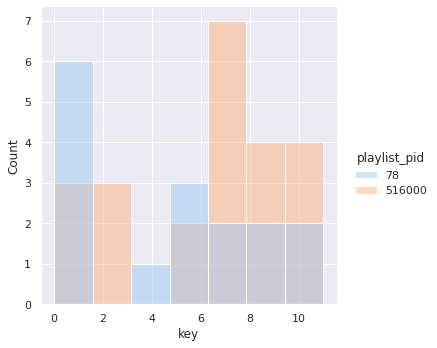

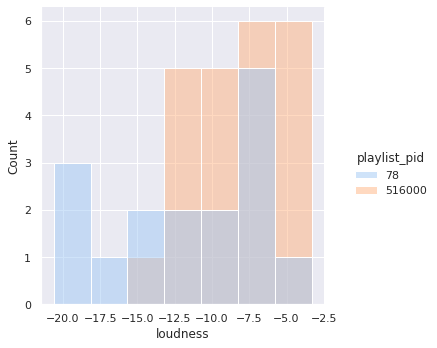

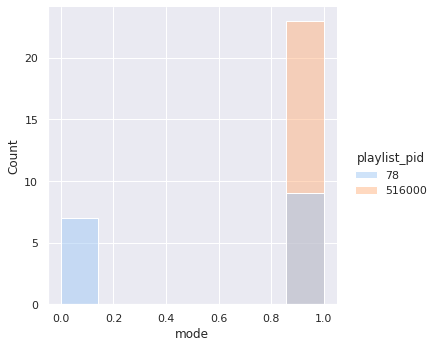

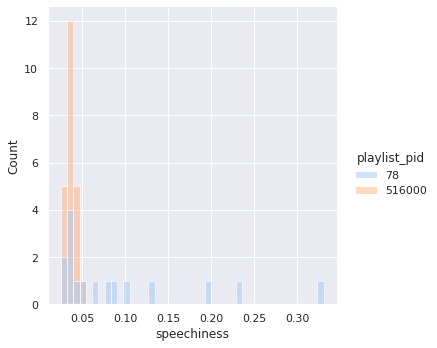

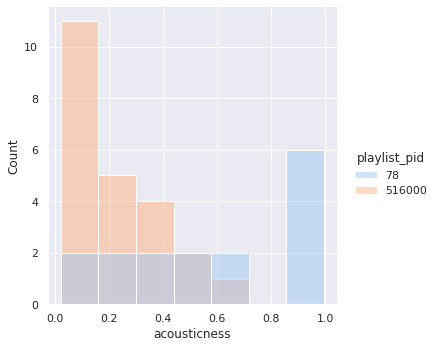

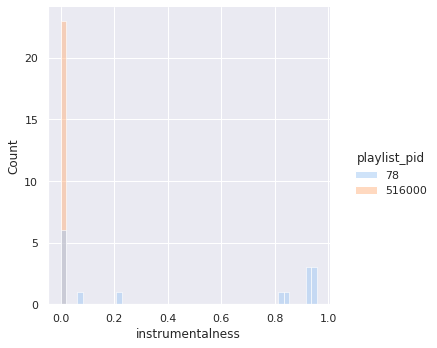

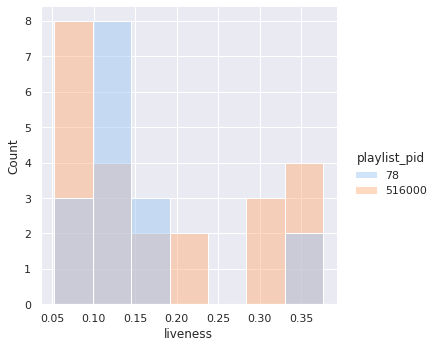

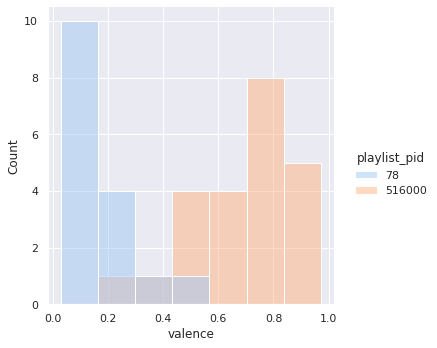

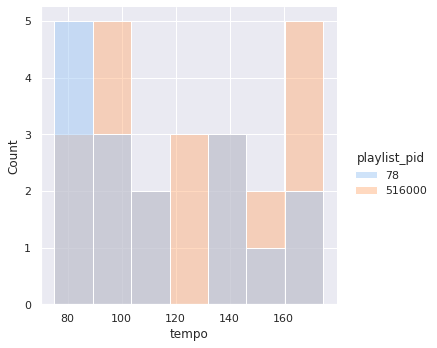

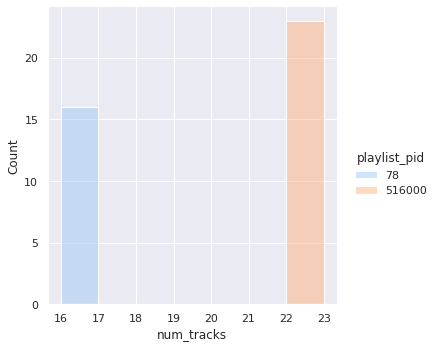

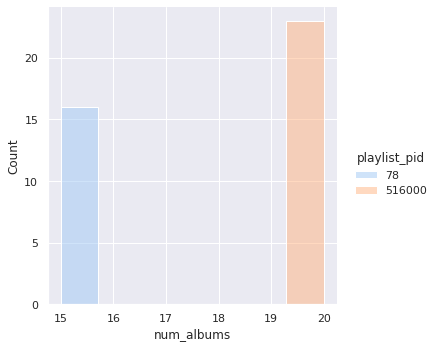

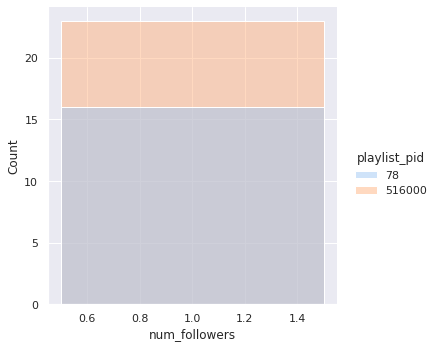

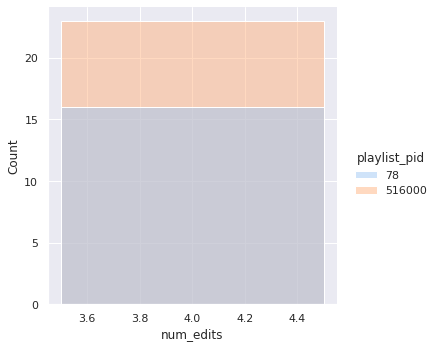

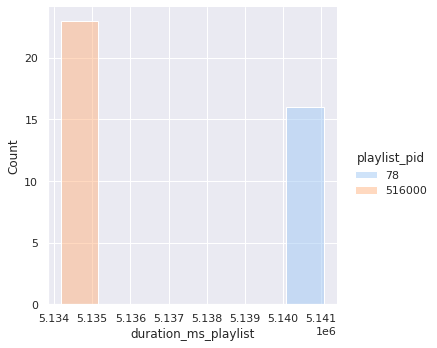

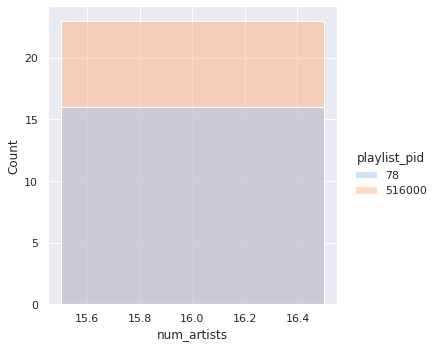

In [41]:
check_result_sim(516000,78,feature_list)

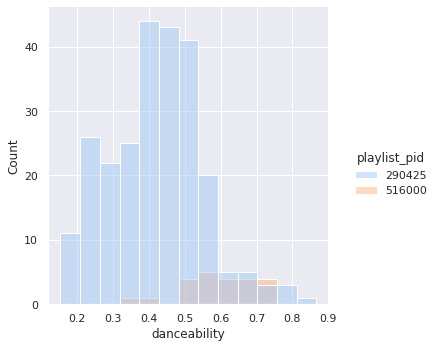

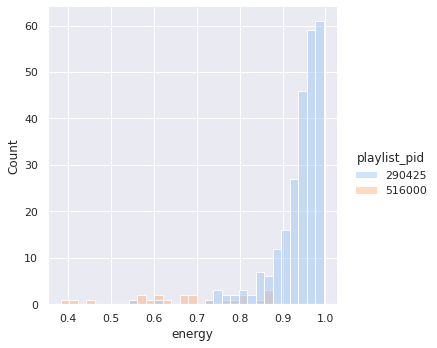

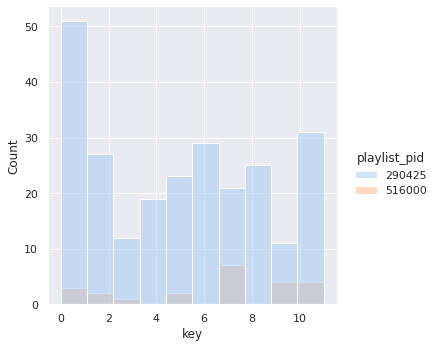

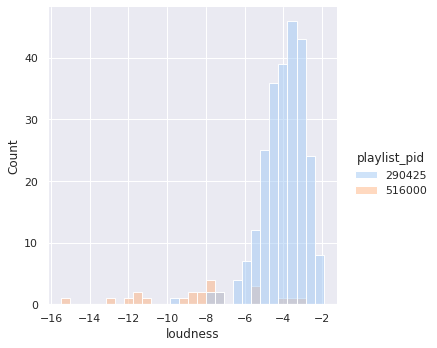

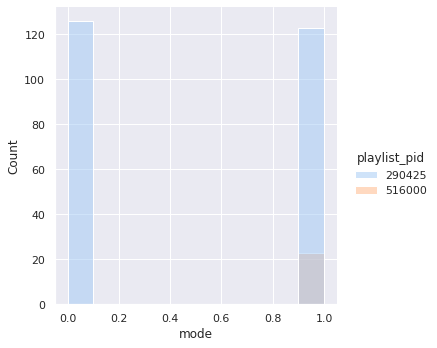

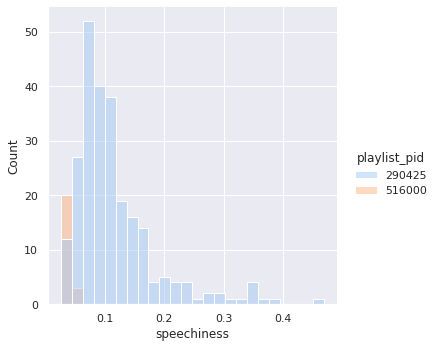

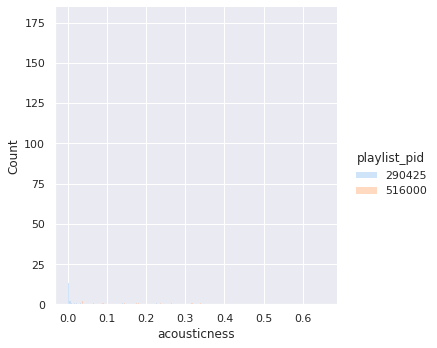

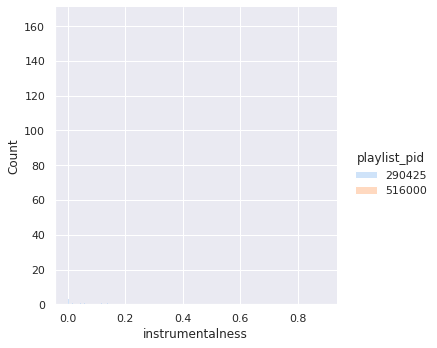

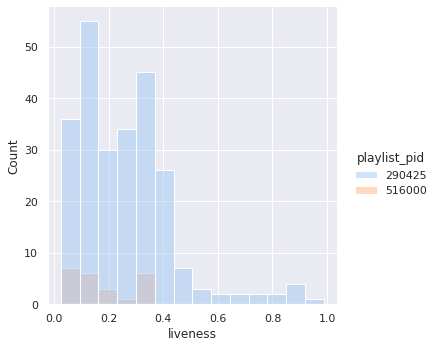

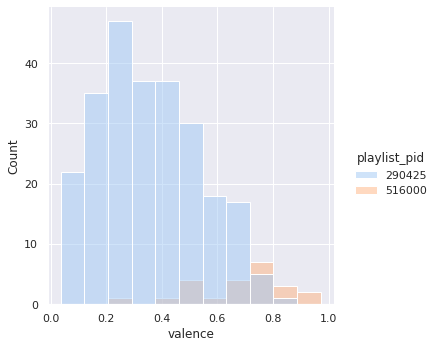

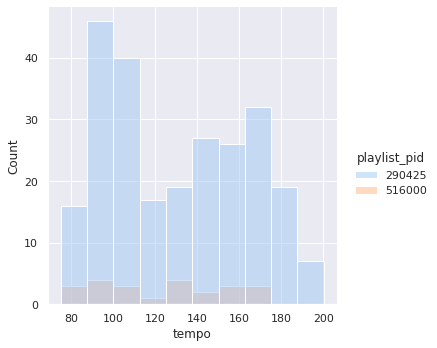

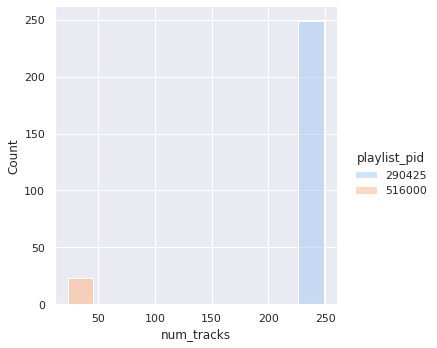

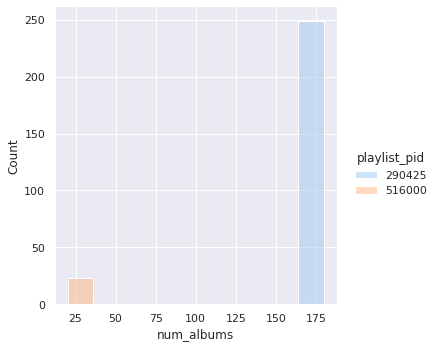

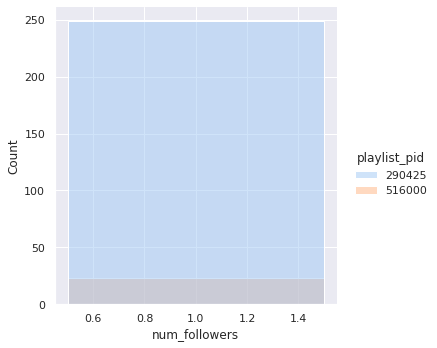

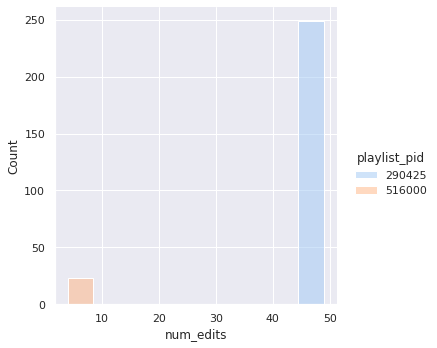

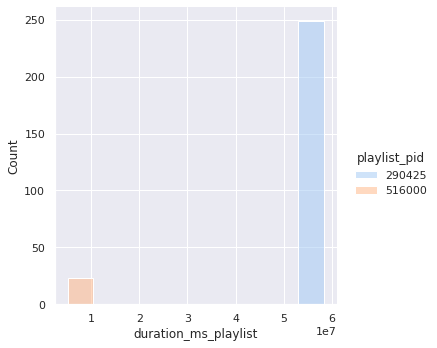

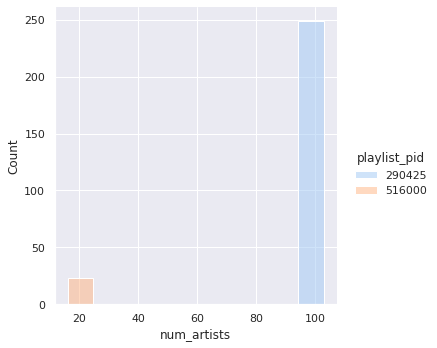

In [42]:
check_result_sim(516000,290425,feature_list)

In [29]:
def check_result_sim_2 (pid1,pid2):
    playlist_1 = df[df['playlist_pid'] == pid1]
    playlist_1 = playlist_1[feature_list+['playlist_pid']]
    playlist_2 = df[df['playlist_pid'] == pid2]
    playlist_2 = playlist_2[feature_list+['playlist_pid']]
    df_merged = pd.concat([playlist_1,playlist_2], ignore_index=True)
    sns.pairplot(df_merged, palette='muted',kind="kde",hue="playlist_pid")

/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/seaborn/distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


IndexError: cannot do a non-empty take from an empty axes.

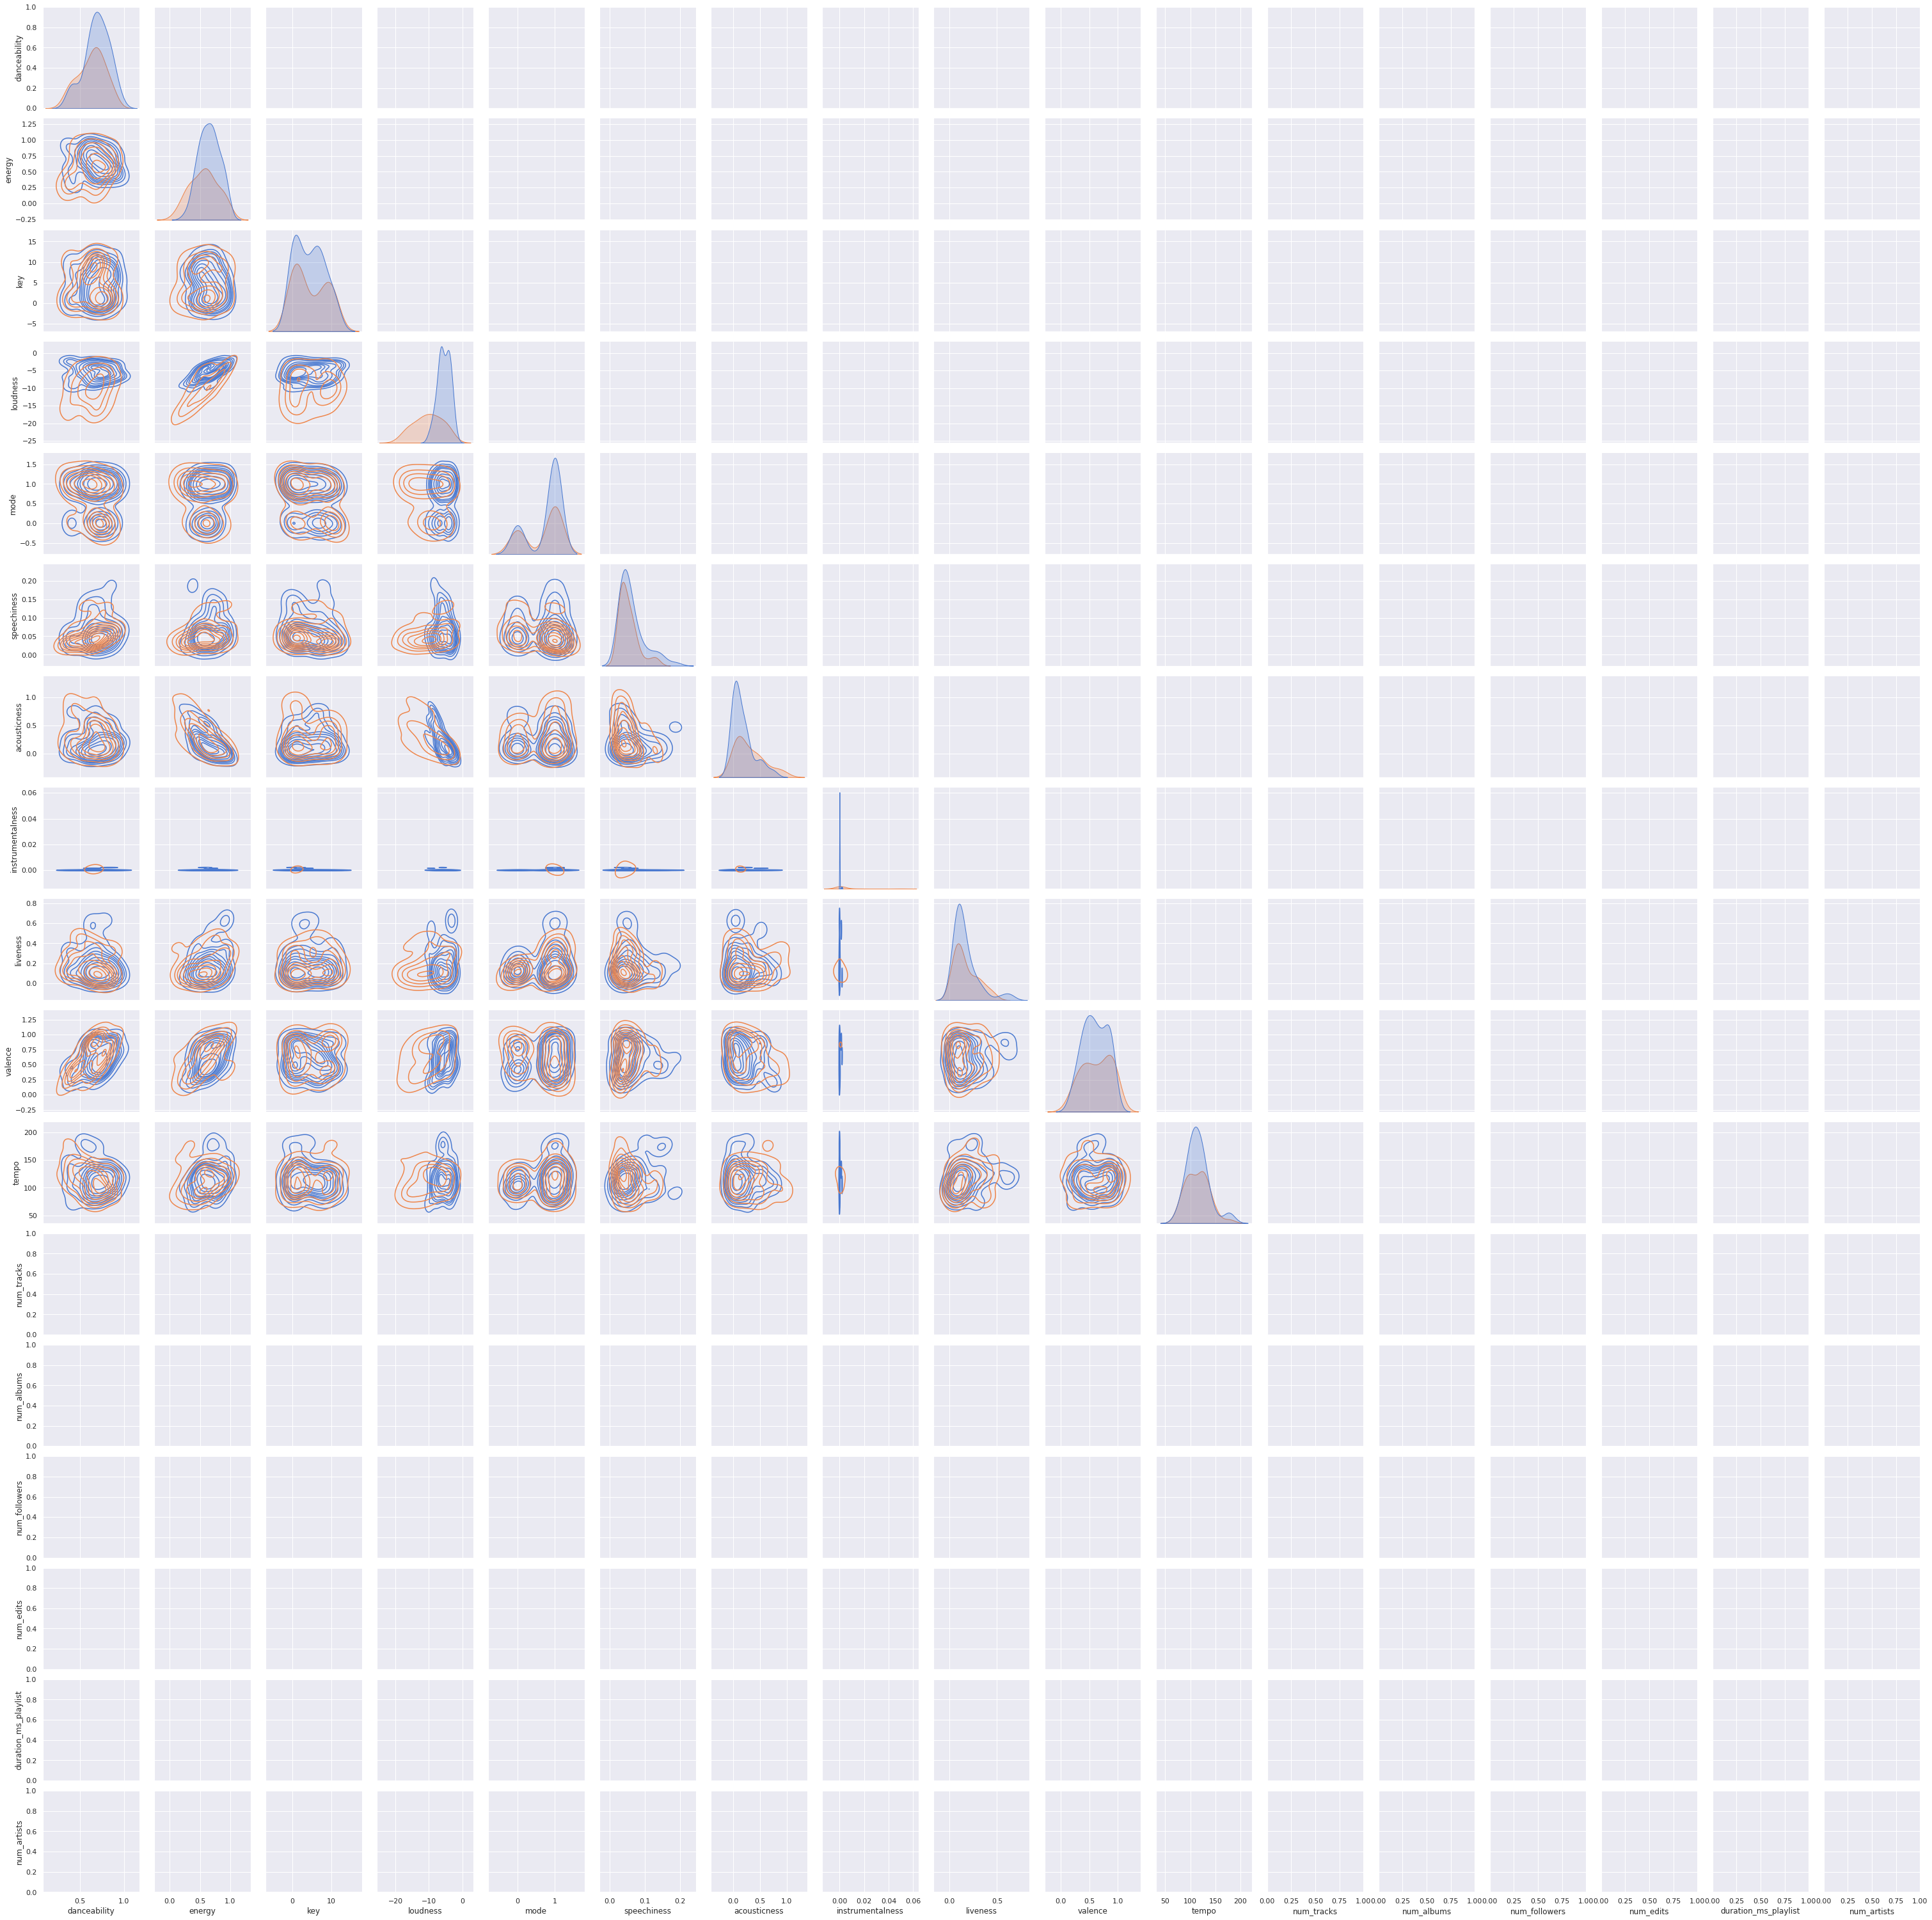

In [30]:
check_result_sim_2(209,516197)

In [15]:
df

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist_pid,name,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,time_signature
0,0,Steve Earle,spotify:track:0VU5k3vCrpqDgUygMjiFYj,spotify:artist:2UBTfUoLI07iRqGeUrwhZh,Copperhead Road,spotify:album:6IjDVtuYfRW1KjqQy2UzPJ,269920,Copperhead Road,516000,Classic Country,...,-15.493,1.0,0.0411,0.02130,0.000103,0.0525,0.706,162.874,audio_features,4.0
1,37,Steve Earle,spotify:track:0VU5k3vCrpqDgUygMjiFYj,spotify:artist:2UBTfUoLI07iRqGeUrwhZh,Copperhead Road,spotify:album:6IjDVtuYfRW1KjqQy2UzPJ,269920,Copperhead Road,516217,current faves,...,-15.493,1.0,0.0411,0.02130,0.000103,0.0525,0.706,162.874,audio_features,4.0
2,1,Tim McGraw,spotify:track:7AHw9SfOITU9Q7sj3V5vxV,spotify:artist:6roFdX1y5BYSbp60OTJWMd,My Next Thirty Years,spotify:album:2EkJjknrgd5DeIH2x9HLjD,217733,A Place In The Sun,516000,Classic Country,...,-7.521,1.0,0.0363,0.26500,0.000005,0.3450,0.601,98.866,audio_features,4.0
3,44,Tim McGraw,spotify:track:7AHw9SfOITU9Q7sj3V5vxV,spotify:artist:6roFdX1y5BYSbp60OTJWMd,My Next Thirty Years,spotify:album:2EkJjknrgd5DeIH2x9HLjD,217733,A Place In The Sun,516828,Countryy,...,-7.521,1.0,0.0363,0.26500,0.000005,0.3450,0.601,98.866,audio_features,4.0
4,2,Jamey Johnson,spotify:track:7CNd7rjfVt74TFlcOcnZgN,spotify:artist:5yhxqYI0JBwUKfXpSEjiM8,In Color,spotify:album:3mb6QMOelljOicaqCo4F6i,290680,That Lonesome Song,516000,Classic Country,...,-8.751,1.0,0.0354,0.39100,0.000004,0.1570,0.251,129.518,audio_features,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373428,44,Evanescence,spotify:track:663Karu2rvKLdnY0eo1n3M,spotify:artist:5nGIFgo0shDenQYSE0Sn7c,Call Me When You're Sober,spotify:album:3lFQ9ihSNR5YD0yi0yTzdC,214706,The Open Door,290999,princess,...,-4.094,1.0,0.0524,0.00193,0.000000,0.2930,0.328,93.410,audio_features,4.0
373429,51,Miley Cyrus,spotify:track:3apgFxCTx6xgpkHtmYn1HH,spotify:artist:5YGY8feqx7naU7z4HrwZM6,Full Circle,spotify:album:0Yu3czJNOQ68fZgkvpjuHL,194480,Breakout,290999,princess,...,-3.680,1.0,0.0581,0.02580,0.000000,0.1390,0.508,145.081,audio_features,4.0
373430,58,Skrillex,spotify:track:6hMnzCnLs4rvlqUVWdTRIk,spotify:artist:5he5w2lnU9x7JFhnwcekXX,Ease My Mind (feat. Niki and the Dove) - Jai W...,spotify:album:7jnaIUsKJTHQ89FgGU9O0x,294452,Ease My Mind v Ragga Bomb Remixes,290999,princess,...,-2.628,0.0,0.1250,0.00223,0.000006,0.0815,0.343,149.950,audio_features,4.0
373431,63,Lily Allen,spotify:track:4XE98WRGbBGRZ7jQ9wIwFt,spotify:artist:13saZpZnCDWOI9D4IJhp1f,Fuck You,spotify:album:4zZKTqu7DkowQnO9Bcx4KX,219893,"It's Not Me, It's You",290999,princess,...,-4.080,0.0,0.0437,0.02710,0.000303,0.0600,0.840,130.009,audio_features,4.0


In [ ]:
# maybe this is a cold start problem, 516000 doesnt have a closed enough playlist.